# Surviving the Titanic

Paul Hendricks
2017-06-25

## Overview

In this vignette, we demonstrate the power of easyml using the popular Titanic dataset.

## Load the data

Install the titanic package from CRAN. This package contains datasets providing information on the fate of passengers on the fatal maiden voyage of the ocean liner “Titanic”, with variables such as economic status (class), sex, age and survival. These data sets are often used as an introduction to machine learning on Kaggle. More details about the dataset can be found there.


In [1]:
%matplotlib inline

In [2]:
import io
import pandas as pd
import requests


# load train
url = 'https://raw.githubusercontent.com/paulhendricks/titanic/master/inst/data-raw/train.csv'
s = requests.get(url).content
titanic_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
print(titanic_train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## Tidy the data

To prepare the data for modeling, we will undergo the following steps:

1. Filter out any places where `Embarked` is `NA`, 
2. Add together `SibSp`, `Parch`, and `1L` to estimate family size,
3. Create binary variables for each of the 2nd and 3rd class memberships, 
4. Create a binary for gender, 
5. Create binary variables for 2 of the ports of embarkation, 
6. Impute mean values of age where `Age` is `NA`.

In [4]:
import numpy as np

titanic_train_2 = titanic_train
mask_1 = titanic_train_2['Embarked'] != np.nan
mask_2 = titanic_train_2['Embarked'] != ''
mask = np.logical_and(mask_1, mask_2)
titanic_train_2 = titanic_train_2.loc[mask, :]
titanic_train_2['Family_Size'] = titanic_train_2['SibSp'] + titanic_train_2['Parch'] + 1
titanic_train_2['Pclass_3'] = 1 * (titanic_train_2['Pclass'] == 3)
titanic_train_2['Sex'] = 1 * (titanic_train_2['Sex'] == 'male')
titanic_train_2['Embarked_Q'] = 1 * (titanic_train_2['Embarked'] == 'Q')
titanic_train_2['Embarked_S'] = 1 * (titanic_train_2['Embarked'] == 'S')
titanic_train_2['Age'] = titanic_train_2['Age'].fillna(np.mean(titanic_train_2['Age']))

## Train a penalized logistic model

To run an `easy_glmnet` model, we pass in the following parameters:

* the data set `titanic_train_2`,
* the name of the dependent variable e.g. `Survived`,
* whether to run a `gaussian` or a `binomial` model, 
* how to preprocess the data; in this case, we use `preprocess_scale` to scale the data, 
* which variables to exclude from the analysis, 
* which variables are categorical variables; these variables are not scaled, if `preprocess_scale` is used, 
* the random state, 
* whether to display a progress bar, 
* how many cores to run the analysis on in parallel.

In [5]:
from easymlpy.glmnet import easy_glmnet

exclude_variables = ['PassengerId', 'Pclass', 'Name',
                     'Ticket', 'Cabin', 'Embarked']
categorical_variables = ['Sex', 'SibSp', 'Parch', 'Family_Size',
                         'Pclass_3', 'Embarked_Q', 'Embarked_S']

results = easy_glmnet(titanic_train_2, 'Survived',
                      family = 'binomial',
                      exclude_variables = exclude_variables,
                      categorical_variables = categorical_variables,
                      random_state = 12345, progress_bar = False,
                      n_samples = 10, n_divisions = 10,
                      n_iterations = 2, n_core = 1)

/Users/paulhendricks/miniconda3/envs/easyml/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Generating coefficients from multiple model builds:
Generating predictions for a single train test split:
Generating measures of model performance over multiple train test splits:


## Assess results

Now let's assess the results of the `easy_glmnet` model.

### Estimates of weights

We can interpret the weights in the following way:

* A 1 standard deviation increase in `Fare` increases the log-odds of survival by 0.14 units, 
* A 1 standard deviation increase in `Age` decreases the log-odds of survival by 0.47 units, 
* If a passenger embarked at the Southampton port, the log-odds of survival decrease by 0.40 units, 
* If a passenger is third class, the log-odds of survival decrease by 1.98 units, 
* If a passenger is second class, the log-odds of survival decrease by 0.77 units, 
* For every unit increase in a passenger's family size, the log-odds of survival decrease by 0.10 units, 
* For every additional Sibling or Spouse in a passenger's family, the log-odds of survival decrease by 0.21 units, 
* If a passenger is male, the log-odds of survival decrease by 2.64 units. 


(<matplotlib.figure.Figure at 0x108236b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x102f2a208>)

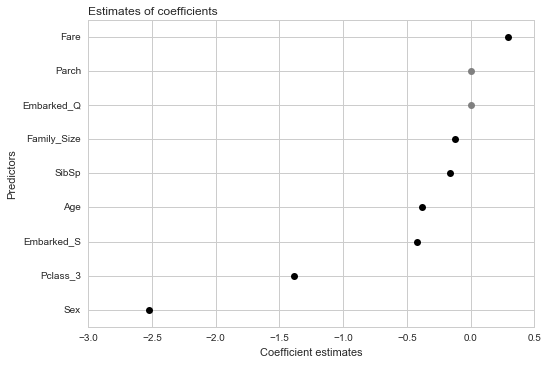

In [6]:
results.plot_coefficients()

### Predictions: ROC Curve

We can examine both the in-sample and out-of-sample ROC curve plots for one particular trian-test split determined by the random state and determine the Area Under the Curve (AUC) as a goodness of fit metric. Here, we see that the in-sample AUC is higher than the out-of-sample AUC, but that both metrics indicate the model fits relatively well.


(<matplotlib.figure.Figure at 0x107e66a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f1047f0>)

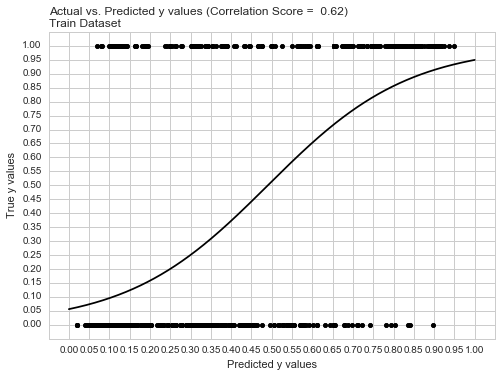

In [7]:
results.plot_predictions_single_train_test_split_train()

(<matplotlib.figure.Figure at 0x10f2cbb70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f2b9eb8>)

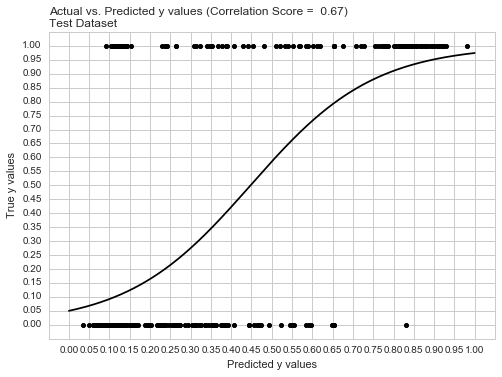

In [8]:
results.plot_predictions_single_train_test_split_test()

### Metrics: AUC

We can examine both the in-sample and out-of-sample AUC metrics for `n_divisions` train-test splits (ususally defaults to 1,000). Again, we see that the in-sample AUC is higher than the out-of-sample AUC, but that both metrics indicate the model fits relatively well.

(<matplotlib.figure.Figure at 0x10f57b7b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f140240>)

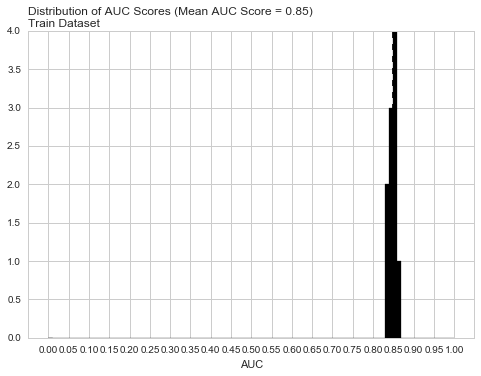

In [9]:
results.plot_model_performance_train()

(<matplotlib.figure.Figure at 0x10f93ee48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f909128>)

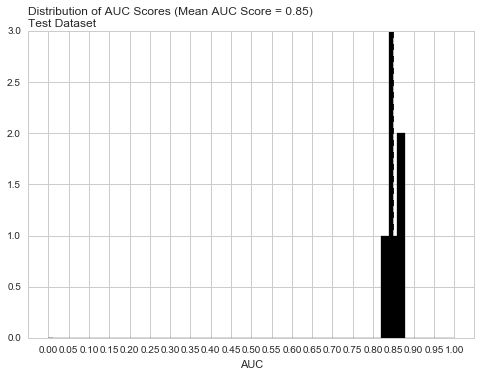

In [10]:
results.plot_model_performance_test()

## Discuss

In this vignette we used `easyml` to easily build and evaluate a penalized binomial regression model to assess the likelihood of passenger surival given a number of attributes. We can continue to finetune the model and identify the most optimal alpha/lambda hyperparameter combination; however, our estimates of the weights make intutive sense and a mean out-of-sample AUC of 0.85 right off the bat is indicative of a good model. 